In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/koushik/spark"

from pyspark.sql import SparkSession
try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("7006SCN_PP") \
    .master("local[4]") \
    .config("spark.driver.memory", "6g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")  # hides WARN messages
print("Spark:", spark.version)

26/02/26 12:35:37 WARN Utils: Your hostname, KoushikPC resolves to a loopback address: 127.0.1.2; using 10.255.255.254 instead (on interface lo)
26/02/26 12:35:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/26 12:35:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/26 12:35:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark: 3.5.1


In [2]:
df_model = spark.read.parquet("/home/koushik/pp_features")

df_sample = df_model.sample(fraction=0.2, seed=42)
print("Sample rows:", df_sample.count())

train_df, test_df = df_sample.randomSplit([0.8, 0.2], seed=42)
train_df.cache()
test_df.cache()
print("Train:", train_df.count(), "| Test:", test_df.count())

Sample rows: 6175091


[Stage 8:>                                                          (0 + 4) / 4]

Train: 4939684 | Test: 1235407


In [3]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(
    featuresCol="features", labelCol="log_price",
    numTrees=20, maxDepth=6, maxBins=64, seed=42
)

rf_model = rf.fit(train_df)
rf_pred = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction")
rf_rmse = evaluator.setMetricName("rmse").evaluate(rf_pred)
rf_r2   = evaluator.setMetricName("r2").evaluate(rf_pred)
rf_mae  = evaluator.setMetricName("mae").evaluate(rf_pred)

print("===== RANDOM FOREST =====")
print(f"RMSE : {rf_rmse:.4f}")
print(f"R2   : {rf_r2:.4f}")
print(f"MAE  : {rf_mae:.4f}")

[Stage 30:===========================================>              (3 + 1) / 4]

===== RANDOM FOREST =====
RMSE : 0.5809
R2   : 0.5393
MAE  : 0.4213


In [4]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="features", labelCol="log_price",
    maxIter=10, regParam=0.1, elasticNetParam=0.8
)

lr_model = lr.fit(train_df)
lr_pred = lr_model.transform(test_df)

lr_rmse = evaluator.setMetricName("rmse").evaluate(lr_pred)
lr_r2   = evaluator.setMetricName("r2").evaluate(lr_pred)
lr_mae  = evaluator.setMetricName("mae").evaluate(lr_pred)

print("===== LINEAR REGRESSION =====")
print(f"RMSE : {lr_rmse:.4f}")
print(f"R2   : {lr_r2:.4f}")
print(f"MAE  : {lr_mae:.4f}")

===== LINEAR REGRESSION =====
RMSE : 0.6366
R2   : 0.4466
MAE  : 0.4688


In [5]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(
    featuresCol="features", labelCol="log_price",
    maxDepth=6, maxBins=64, seed=42
)

dt_model = dt.fit(train_df)
dt_pred = dt_model.transform(test_df)

dt_rmse = evaluator.setMetricName("rmse").evaluate(dt_pred)
dt_r2   = evaluator.setMetricName("r2").evaluate(dt_pred)
dt_mae  = evaluator.setMetricName("mae").evaluate(dt_pred)

print("===== DECISION TREE =====")
print(f"RMSE : {dt_rmse:.4f}")
print(f"R2   : {dt_r2:.4f}")
print(f"MAE  : {dt_mae:.4f}")

===== DECISION TREE =====
RMSE : 0.5789
R2   : 0.5424
MAE  : 0.4186


In [6]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(
    featuresCol="features", labelCol="log_price",
    maxIter=20, maxDepth=5, maxBins=64, seed=42
)

gbt_model = gbt.fit(train_df)
gbt_pred = gbt_model.transform(test_df)

gbt_rmse = evaluator.setMetricName("rmse").evaluate(gbt_pred)
gbt_r2   = evaluator.setMetricName("r2").evaluate(gbt_pred)
gbt_mae  = evaluator.setMetricName("mae").evaluate(gbt_pred)

print("===== GRADIENT BOOSTED TREES =====")
print(f"RMSE : {gbt_rmse:.4f}")
print(f"R2   : {gbt_r2:.4f}")
print(f"MAE  : {gbt_mae:.4f}")

===== GRADIENT BOOSTED TREES =====
RMSE : 0.5354
R2   : 0.6086
MAE  : 0.3776


In [7]:
print("\n========== MODEL COMPARISON ==========")
print(f"{'Model':<25} {'RMSE':>8} {'R2':>8} {'MAE':>8}")
print(f"{'Random Forest':<25} {rf_rmse:>8.4f} {rf_r2:>8.4f} {rf_mae:>8.4f}")
print(f"{'Linear Regression':<25} {lr_rmse:>8.4f} {lr_r2:>8.4f} {lr_mae:>8.4f}")
print(f"{'Decision Tree':<25} {dt_rmse:>8.4f} {dt_r2:>8.4f} {dt_mae:>8.4f}")
print(f"{'Gradient Boosted Trees':<25} {gbt_rmse:>8.4f} {gbt_r2:>8.4f} {gbt_mae:>8.4f}")


========== MODEL COMPARISON ==========
Model                         RMSE       R2      MAE
Random Forest               0.5809   0.5393   0.4213
Linear Regression           0.6366   0.4466   0.4688
Decision Tree               0.5789   0.5424   0.4186
Gradient Boosted Trees      0.5354   0.6086   0.3776


In [8]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import time

evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")

tune_df = df_sample.sample(fraction=0.3, seed=42)
train_tune, test_tune = tune_df.randomSplit([0.8, 0.2], seed=42)
train_tune.cache()
print("Tuning rows:", train_tune.count())

[Stage 262:==============>                                          (1 + 3) / 4]

Tuning rows: 1483197


In [9]:
rf_tune = RandomForestRegressor(
    featuresCol="features", labelCol="log_price", seed=42
)

rf_grid = ParamGridBuilder() \
    .addGrid(rf_tune.numTrees, [10, 20]) \
    .addGrid(rf_tune.maxDepth, [4, 6]) \
    .addGrid(rf_tune.maxBins,  [32, 64]) \
    .build()

rf_cv = CrossValidator(
    estimator=rf_tune,
    estimatorParamMaps=rf_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2,
    seed=42
)

t = time.time()
rf_cv_model = rf_cv.fit(train_tune)
print(f"RF Tuning done in {time.time()-t:.1f}s")

# Best params
best_rf = rf_cv_model.bestModel
print("\n BEST RF PARAMS")
print("numTrees :", best_rf.getNumTrees)
print("maxDepth :", best_rf.getOrDefault("maxDepth"))
print("maxBins  :", best_rf.getOrDefault("maxBins"))

# Evaluate best model
best_rf_pred = rf_cv_model.transform(test_tune)
best_rf_rmse = evaluator.setMetricName("rmse").evaluate(best_rf_pred)
best_rf_r2   = evaluator.setMetricName("r2").evaluate(best_rf_pred)
best_rf_mae  = evaluator.setMetricName("mae").evaluate(best_rf_pred)

print(f"\nBest RF RMSE : {best_rf_rmse:.4f}")
print(f"Best RF R2   : {best_rf_r2:.4f}")
print(f"Best RF MAE  : {best_rf_mae:.4f}")

RF Tuning done in 439.7s

 BEST RF PARAMS
numTrees : 20
maxDepth : 6
maxBins  : 32


[Stage 653:>                                                        (0 + 4) / 4]


Best RF RMSE : 0.5787
Best RF R2   : 0.5409
Best RF MAE  : 0.4206


In [10]:
gbt_tune = GBTRegressor(
    featuresCol="features", labelCol="log_price", seed=42
)

gbt_grid = ParamGridBuilder() \
    .addGrid(gbt_tune.maxIter,  [10, 20]) \
    .addGrid(gbt_tune.maxDepth, [4, 5]) \
    .addGrid(gbt_tune.stepSize, [0.05, 0.1]) \
    .build()

gbt_cv = CrossValidator(
    estimator=gbt_tune,
    estimatorParamMaps=gbt_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2,
    seed=42
)

t = time.time()
gbt_cv_model = gbt_cv.fit(train_tune)
print(f"GBT Tuning done in {time.time()-t:.1f}s")

best_gbt = gbt_cv_model.bestModel
print("\n===== BEST GBT PARAMS =====")
print("maxIter  :", best_gbt.getOrDefault("maxIter"))
print("maxDepth :", best_gbt.getOrDefault("maxDepth"))
print("stepSize :", best_gbt.getOrDefault("stepSize"))

best_gbt_pred = gbt_cv_model.transform(test_tune)
best_gbt_rmse = evaluator.setMetricName("rmse").evaluate(best_gbt_pred)
best_gbt_r2   = evaluator.setMetricName("r2").evaluate(best_gbt_pred)
best_gbt_mae  = evaluator.setMetricName("mae").evaluate(best_gbt_pred)

print(f"\nBest GBT RMSE : {best_gbt_rmse:.4f}")
print(f"Best GBT R2   : {best_gbt_r2:.4f}")
print(f"Best GBT MAE  : {best_gbt_mae:.4f}")

GBT Tuning done in 2132.3s

===== BEST GBT PARAMS =====
maxIter  : 20
maxDepth : 5
stepSize : 0.1


[Stage 4229:>                                                       (0 + 4) / 4]


Best GBT RMSE : 0.5322
Best GBT R2   : 0.6117
Best GBT MAE  : 0.3760


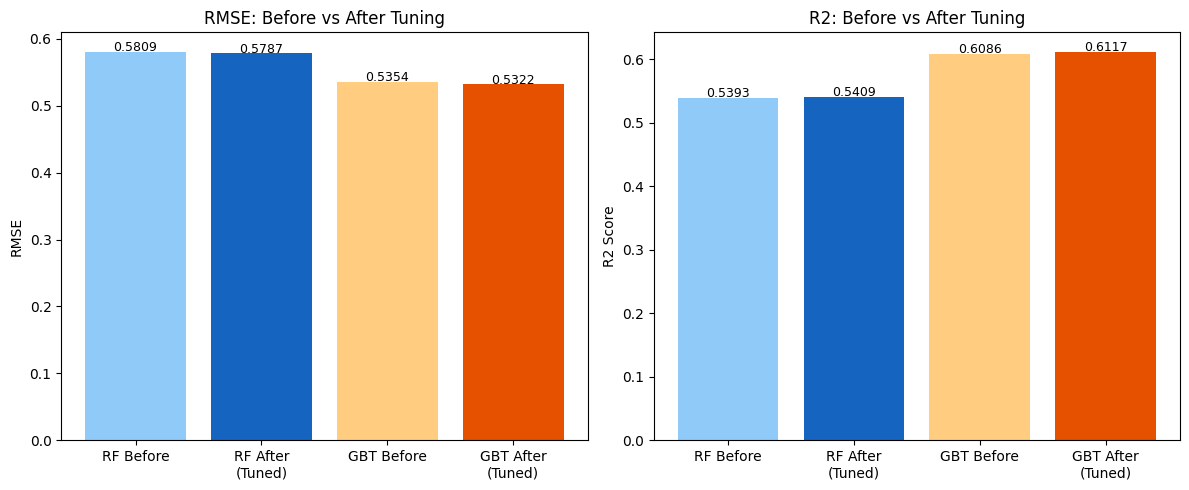

In [11]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["RF Before", "RF After\n(Tuned)", "GBT Before", "GBT After\n(Tuned)"]
rmse_compare = [rf_rmse, best_rf_rmse, gbt_rmse, best_gbt_rmse]
r2_compare   = [rf_r2,   best_rf_r2,   gbt_r2,   best_gbt_r2]

x = np.arange(len(labels))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE
bars1 = axes[0].bar(x, rmse_compare, color=["#90CAF9","#1565C0","#FFCC80","#E65100"])
axes[0].set_title("RMSE: Before vs After Tuning")
axes[0].set_xticks(x); axes[0].set_xticklabels(labels)
axes[0].set_ylabel("RMSE")
for bar, val in zip(bars1, rmse_compare):
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.001,
                 f"{val:.4f}", ha="center", fontsize=9)

# R2
bars2 = axes[1].bar(x, r2_compare, color=["#90CAF9","#1565C0","#FFCC80","#E65100"])
axes[1].set_title("R2: Before vs After Tuning")
axes[1].set_xticks(x); axes[1].set_xticklabels(labels)
axes[1].set_ylabel("R2 Score")
for bar, val in zip(bars2, r2_compare):
    axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.001,
                 f"{val:.4f}", ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("hypertuning_comparison.png", dpi=150)
plt.show()

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import time

pdf = df_sample.sample(fraction=0.05, seed=42).toPandas()
X = np.array(pdf["features"].apply(lambda x: x.toArray()).tolist())
y = pdf["log_price"].values

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train:", len(X_train), "| Test:", len(X_test))

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree":     DecisionTreeRegressor(max_depth=6),
    "Random Forest":     RandomForestRegressor(n_estimators=20, max_depth=6, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=20, max_depth=5, random_state=42)
}

print(f"\n{'Model':<22} {'RMSE':>8} {'R2':>8} {'MAE':>8} {'Time':>7}")


sk_results = {}
for name, model in models.items():
    t = time.time()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    elapsed = time.time() - t

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2   = r2_score(y_test, pred)
    mae  = mean_absolute_error(y_test, pred)
    sk_results[name] = {"RMSE": rmse, "R2": r2, "MAE": mae, "Time": elapsed}

    print(f"{name:<22} {rmse:>8.4f} {r2:>8.4f} {mae:>8.4f} {elapsed:>6.1f}s")

Train: 247028 | Test: 61757

Model                      RMSE       R2      MAE    Time
Linear Regression        0.6191   0.3907   0.3993    8.8s
Decision Tree            0.6905   0.2420   0.4720    7.5s
Random Forest            0.6842   0.2558   0.4666   90.0s
Gradient Boosting        0.6815   0.2617   0.4622  116.2s


In [13]:
import time
import matplotlib.pyplot as plt
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")

print("STRONG SCALING ")
print("Fixed data size, increasing cores\n")

data_fixed = df_model.sample(fraction=0.1, seed=42)  # fixed dataset
cores_list = [1, 2, 4]
strong_times = []

for cores in cores_list:
    # Restart spark with different cores
    spark.stop()
    spark = SparkSession.builder \
        .appName("StrongScaling") \
        .master(f"local[{cores}]") \
        .config("spark.driver.memory", "6g") \
        .config("spark.sql.shuffle.partitions", "50") \
        .getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")

    df_fixed = spark.read.parquet("/home/koushik/pp_features").sample(fraction=0.1, seed=42)
    tr, te = df_fixed.randomSplit([0.8, 0.2], seed=42)

    t = time.time()
    model = DecisionTreeRegressor(featuresCol="features", labelCol="log_price",
                                   maxDepth=5, maxBins=32).fit(tr)
    elapsed = time.time() - t
    strong_times.append(elapsed)
    print(f"Cores: {cores} → Time: {elapsed:.1f}s")

STRONG SCALING 
Fixed data size, increasing cores



Cores: 1 → Time: 96.3s


java.util.concurrent.RejectedExecutionException: Task scala.concurrent.impl.CallbackRunnable@713a32e1 rejected from java.util.concurrent.ThreadPoolExecutor@3fe790ed[Shutting down, pool size = 1, active threads = 1, queued tasks = 0, completed tasks = 84]
	at java.base/java.util.concurrent.ThreadPoolExecutor$AbortPolicy.rejectedExecution(ThreadPoolExecutor.java:2065)
	at java.base/java.util.concurrent.ThreadPoolExecutor.reject(ThreadPoolExecutor.java:833)
	at java.base/java.util.concurrent.ThreadPoolExecutor.execute(ThreadPoolExecutor.java:1365)
	at scala.concurrent.impl.ExecutionContextImpl$$anon$4.execute(ExecutionContextImpl.scala:138)
	at scala.concurrent.impl.CallbackRunnable.executeWithValue(Promise.scala:72)
	at scala.concurrent.impl.Promise$DefaultPromise.$anonfun$tryComplete$1(Promise.scala:288)
	at scala.concurrent.impl.Promise$DefaultPromise.$anonfun$tryComplete$1$adapted(Promise.scala:288)
	at scala.concurrent.impl.Promise$DefaultPromise.tryComplete(Promise.scala:288)
	at sc

Cores: 2 → Time: 55.6s


[Stage 13:==============>                                           (1 + 3) / 4]

Cores: 4 → Time: 28.2s


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

df = spark.read.parquet("/home/koushik/pp_features") \
         .sample(fraction=0.02, seed=42).toPandas()  # only 2% = fast

X = np.array(df["features"].apply(lambda x: x.toArray()).tolist())
y = df["log_price"].values

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(" Data loaded:", len(X_train), "train |", len(X_test), "test")
print("Training small models for plots only...")

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

rf  = RandomForestRegressor(n_estimators=5, max_depth=4, random_state=42, n_jobs=-1).fit(X_train, y_train)
dt  = DecisionTreeRegressor(max_depth=4, random_state=42).fit(X_train, y_train)
lr  = LinearRegression(n_jobs=-1).fit(X_train, y_train)
gbt = GradientBoostingRegressor(n_estimators=5, max_depth=3, random_state=42).fit(X_train, y_train)


 Data loaded: 494270 train | 123568 test
Training small models for plots only...


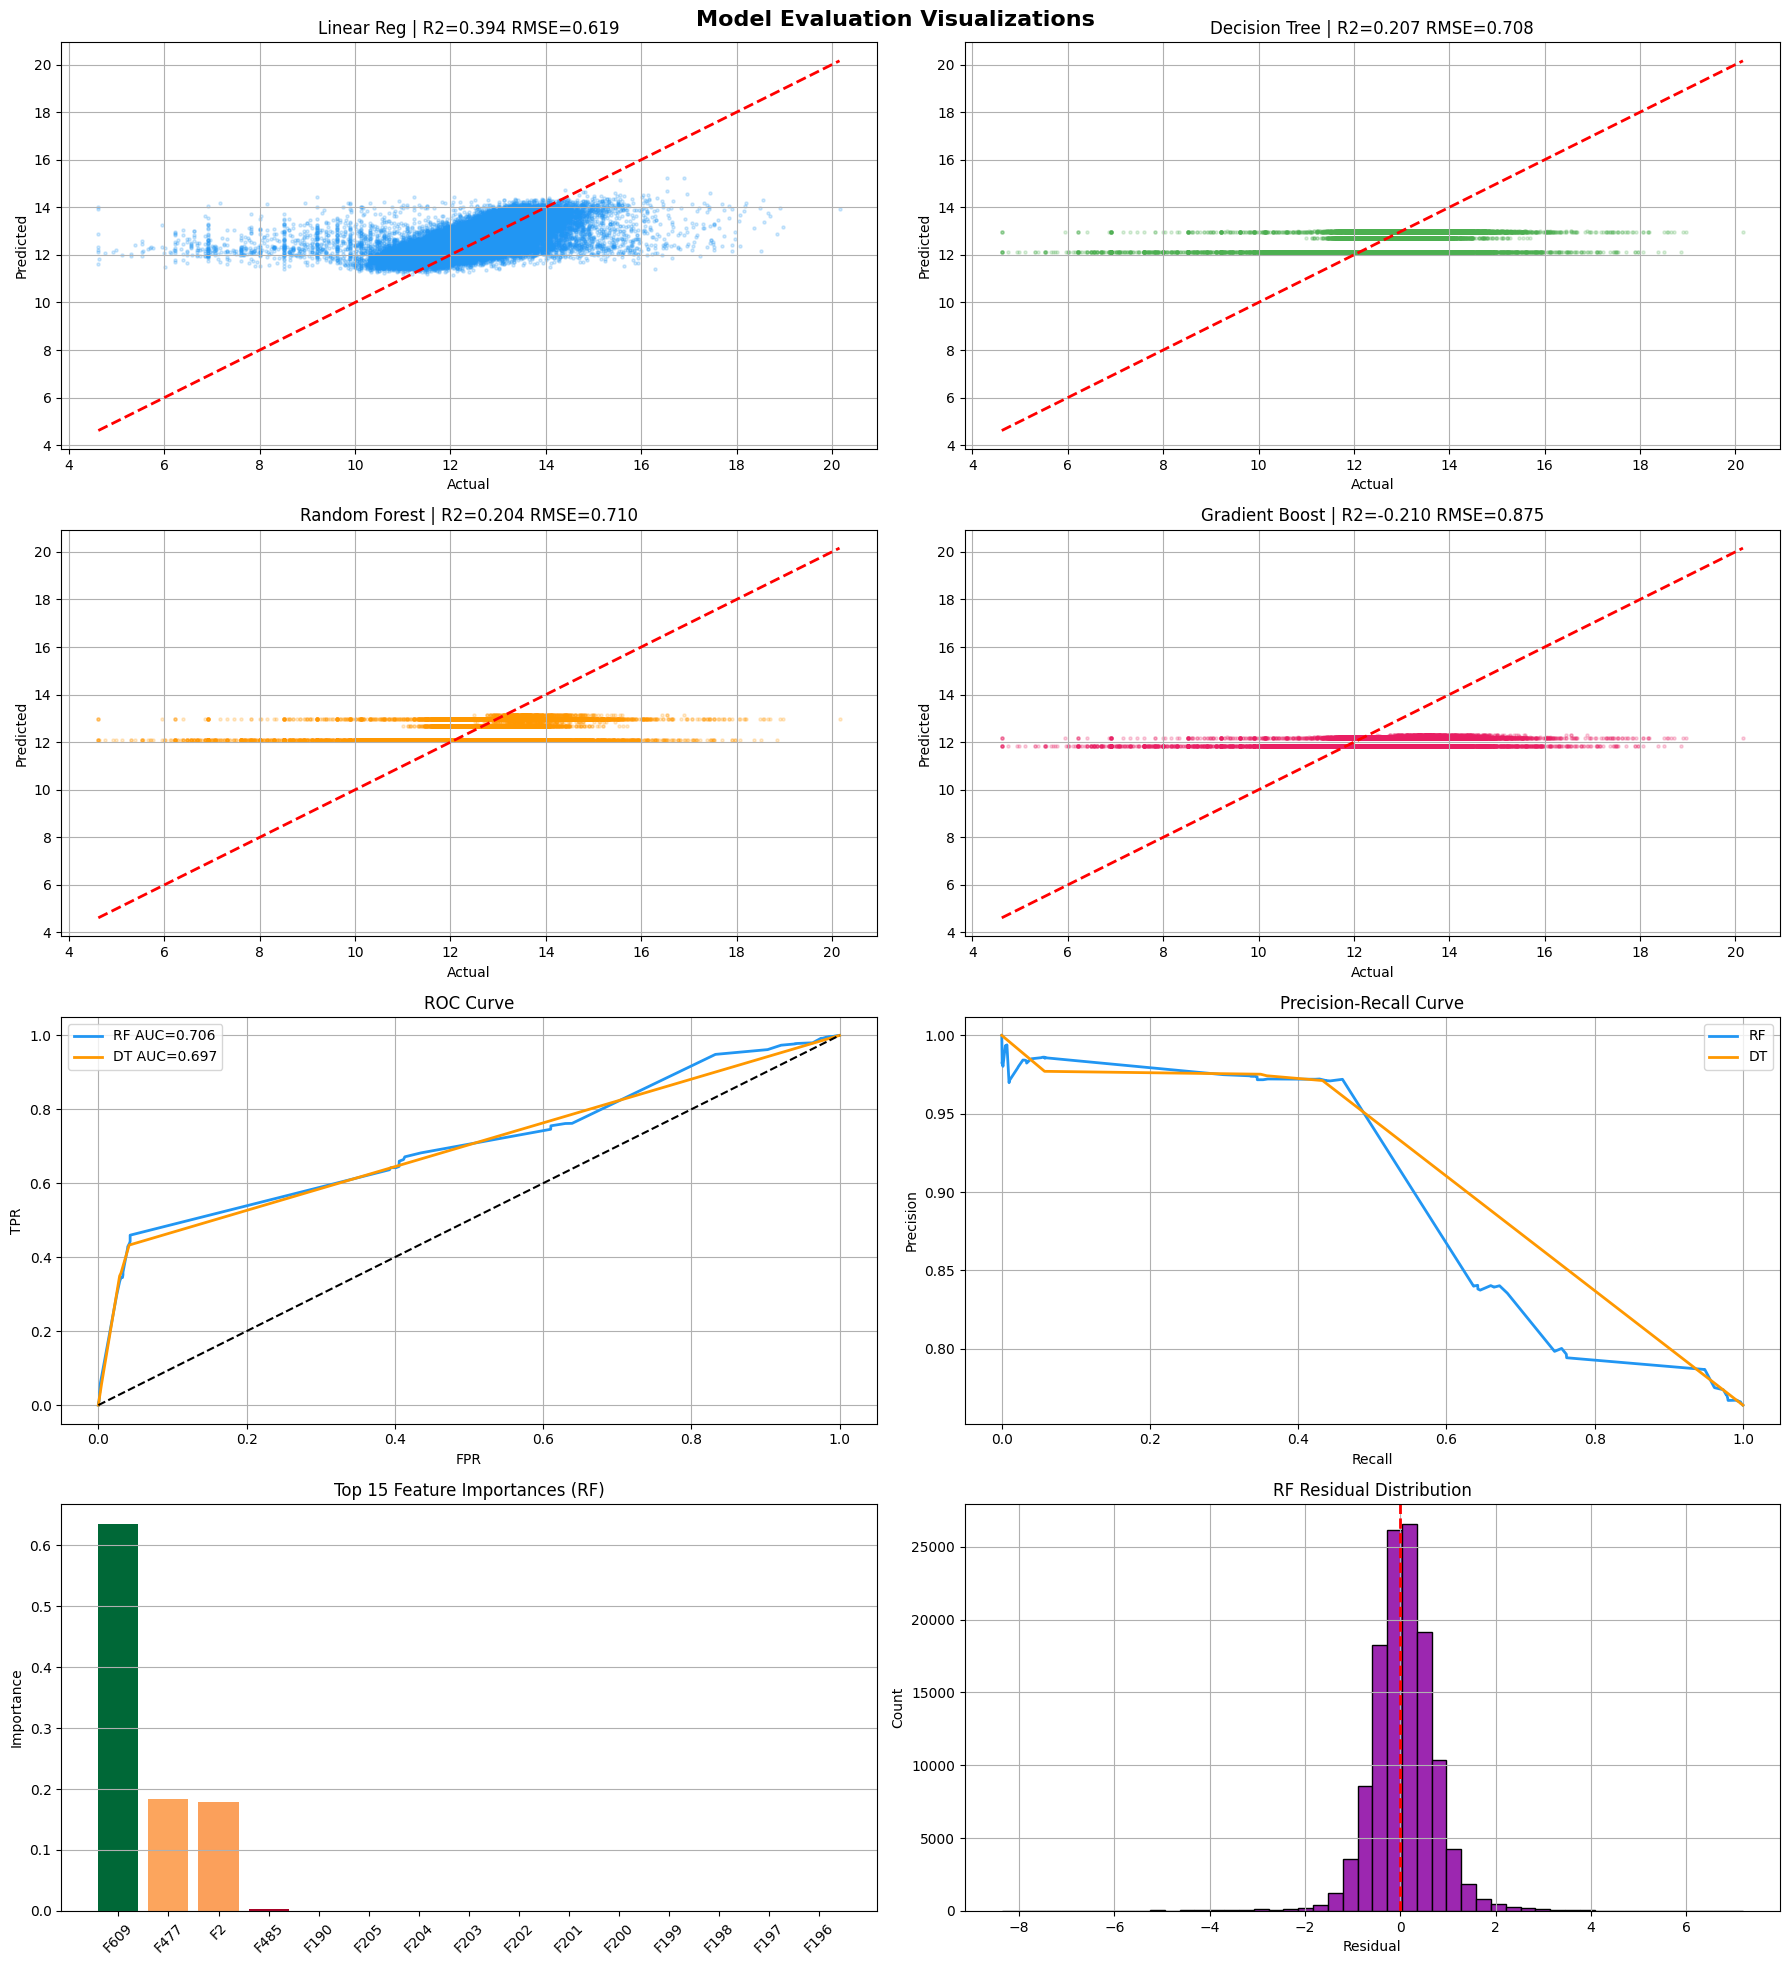

In [4]:
fig = plt.figure(figsize=(18, 20))


models_dict = {"Linear Reg": lr, "Decision Tree": dt,
               "Random Forest": rf, "Gradient Boost": gbt}
colors = ["#2196F3","#4CAF50","#FF9800","#E91E63"]

for i, (name, model, color) in enumerate(zip(
        models_dict.keys(), models_dict.values(), colors)):
    ax = fig.add_subplot(4, 2, i+1)
    pred = model.predict(X_test)
    ax.scatter(y_test, pred, alpha=0.2, s=5, color=color)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()], "r--", lw=2)
    r2   = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    ax.set_title(f"{name} | R2={r2:.3f} RMSE={rmse:.3f}")
    ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")
    ax.grid(True)

median_price  = np.median(y)
y_train_c = (y_train > median_price).astype(int)
y_test_c  = (y_test  > median_price).astype(int)

rf_clf = RandomForestClassifier(n_estimators=5, max_depth=4, random_state=42, n_jobs=-1).fit(X_train, y_train_c)
dt_clf = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train, y_train_c)

ax_roc = fig.add_subplot(4, 2, 5)
ax_pr  = fig.add_subplot(4, 2, 6)

for name, model, color in [("RF",  rf_clf, "#2196F3"),
                             ("DT",  dt_clf, "#FF9800")]:
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_c, proba)
    ax_roc.plot(fpr, tpr, color=color, lw=2,
                label=f"{name} AUC={auc(fpr,tpr):.3f}")
    prec, rec, _ = precision_recall_curve(y_test_c, proba)
    ax_pr.plot(rec, prec, color=color, lw=2, label=name)

ax_roc.plot([0,1],[0,1],"k--"); ax_roc.set_title("ROC Curve")
ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
ax_roc.legend(); ax_roc.grid(True)

ax_pr.set_title("Precision-Recall Curve")
ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
ax_pr.legend(); ax_pr.grid(True)


ax_fi = fig.add_subplot(4, 2, 7)
imp     = rf.feature_importances_
top_idx = np.argsort(imp)[-15:][::-1]
ax_fi.bar(range(15), imp[top_idx],
          color=plt.cm.RdYlGn(imp[top_idx]/imp[top_idx].max()))
ax_fi.set_title("Top 15 Feature Importances (RF)")
ax_fi.set_xticks(range(15))
ax_fi.set_xticklabels([f"F{i}" for i in top_idx], rotation=45)
ax_fi.set_ylabel("Importance"); ax_fi.grid(True, axis="y")


ax_res = fig.add_subplot(4, 2, 8)
residuals = y_test - rf.predict(X_test)
ax_res.hist(residuals, bins=50, color="#9C27B0", edgecolor="black")
ax_res.axvline(0, color="red", lw=2, linestyle="--")
ax_res.set_title("RF Residual Distribution")
ax_res.set_xlabel("Residual"); ax_res.set_ylabel("Count")
ax_res.grid(True)

plt.suptitle("Model Evaluation Visualizations", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("evaluation_plots.png", dpi=150, bbox_inches="tight")
plt.show()